This notebook is heavily inspired by the notebook in this [Github repo](https://github.com/nicknochnack/TFODCourse) by [Nicholas Renotte](https://youtu.be/yqkISICHH-U?list=PLEG-yoFSLEJ7inw5rNtyqaFAlOHkyWU3t).

# Install TFOD (only need to install once in a virtual environment)

In [1]:
import os

In [8]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    # clone the TensorFlow Model Garden repo to use it for TFOD API installation
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection and dependencies such as protobuf and protoc (for Windows)

if os.name == 'posix':
    # 'posix' is for Linux (also to use in Colab Notebook)
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name == 'nt':
    # 'nt' is for Windows
    print("[INFO] Downloading protobuf dependencies ...")
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    # move the protoc zip file into the desired path, PROTOC_PATH
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    # unzip the zip file
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    # add the path of $PROTOC_PATH/bin into the PATH in environment variable
    # to be able to run `protoc` as a command in terminal
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    # run the `protoc` command and install all the dependencies for TFOD API
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [10]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify all the installation above works for TFOD API
!python {VERIFICATION_SCRIPT}

2021-08-11 15:33:02.964732: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
Running tests under Python 3.8.11: C:\Users\user\anaconda3\envs\tfod\python.exe
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2021-08-11 15:33:07.052802: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library nvcuda.dll
2021-08-11 15:33:07.072630: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.8475GHz coreCount: 10 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 178.99GiB/s
2021-08-11 15:33:07.073065: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
2021-08-11 15:33:07.077667: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cubla

In [ ]:
!pip uninstall protobuf -y
!pip install protobuf

# 0. Setup Config and Paths

In [3]:
# restart your Jupyter kernel and run this after installation to confirm the installation works
import object_detection

In [4]:
import os
# wget is used to download files from URLs
import wget
# shutil is used to move files
import shutil
import tensorflow as tf

In [5]:
# check whether tensorflow has access to GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

If this returns an empty list then there is either something wrong with your tensorflow installation, or your machine has no GPU. If you want to use TensorFlow with GPU (recommended), please check this [video link here](https://youtu.be/hHWkvEcDBO0) to try to debug and make sure the cell above returns something like this:

`[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]`

In [6]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
LABEL_MAP_NAME = 'label_map.pbtxt'

CLASS_NAMES = ['5', '10', '20', '50']

In [7]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [8]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    # this generate_tfrecord.py script is obtained from https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html
    # to convert our PascalVOC XML annotation files into TFRecords which will be used by the TFOD API
    'GENERATE_TF_RECORD': os.path.join('utils', 'generate_tfrecord.py'),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [7]:
# create all the necessary paths if not exists yet
for path in paths.values():
    if not os.path.exists(path):
        os.makedirs(path)

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo

In [ ]:
wget.download(PRETRAINED_MODEL_URL)
pretrained_tarfile = PRETRAINED_MODEL_NAME + '.tar.gz'
!tar -zxvf {pretrained_tarfile}
shutil.move(PRETRAINED_MODEL_NAME, paths['PRETRAINED_MODEL_PATH'])
os.remove(pretrained_tarfile)

# 2. Create Label Map File

In [17]:
CLASS_NAMES

['5', '10', '20', '50']

In [8]:
with open(files['LABELMAP'], 'w') as f:
    for idx, label in enumerate(CLASS_NAMES, start=1):
        f.write('item { \n')
        f.write(f'\tname: \'{label}\'\n')
        f.write(f'\tid: {idx}\n')
        f.write('}\n')

In [9]:
print(files['LABELMAP'])
with open(files['LABELMAP']) as f:
    print(f.read())

Tensorflow\workspace\annotations\label_map.pbtxt
item { 
	name: '5'
	id: 1
}
item { 
	name: '10'
	id: 2
}
item { 
	name: '20'
	id: 3
}
item { 
	name: '50'
	id: 4
}



# 3. Create TF records

OPTIONAL IF RUNNING ON COLAB
- Upload the archive.tar.gz that we saved at the end of the previous notebook,
- upload it to the "image" folder in the Google Colab by clicking "Upload" at "image" folder, refer the image below
- Then untar it by running the next code cell

![upload_colab](images/upload_colab.png)

In [34]:
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [8]:
!python {files['GENERATE_TF_RECORD']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -e jpg -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['GENERATE_TF_RECORD']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -e jpg -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow\workspace\annotations\train.record
Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


# 4. Copy Model Config to Training Folder

In [9]:
shutil.copy2(os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config'), os.path.join(paths['CHECKPOINT_PATH']))

'Tensorflow\\workspace\\models\\my_ssd_mobnet\\pipeline.config'

# 5. Update Config For Transfer Learning

In [7]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [8]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
config

{'model': ssd {
   num_classes: 4
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   match

In [9]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

In [10]:
pipeline_config.model.ssd.num_classes = len(CLASS_NAMES)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [11]:
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:
    f.write(config_text)

# 6. Train the model

In [18]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')
# change the training steps as necessary, recommended start with 10 to test whether it's working, then train for at least 2000 steps
NUM_TRAIN_STEPS = 500

In [19]:
command = f"python {TRAINING_SCRIPT} --model_dir={paths['CHECKPOINT_PATH']} --pipeline_config_path={files['PIPELINE_CONFIG']} --num_train_steps={NUM_TRAIN_STEPS}"
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --num_train_steps=500


Copy this command from the cell output above and run it in your terminal at the root directory of this project to start training. Running in terminal instead of Jupyter notebook would be able to see the training process and outputs clearly.

NOTE: Unless you really want to try to train this on your machine locally, it is highly recommended that you run the training in Google Colab **especially if** you don't have access to a good GPU.

In [17]:
# our model checkpoints reside in this path
paths['CHECKPOINT_PATH']

'Tensorflow\\workspace\\models\\my_ssd_mobnet'

# 7. Evaluate the Model

In [15]:
command = f"python {TRAINING_SCRIPT} --model_dir={paths['CHECKPOINT_PATH']} --pipeline_config_path={files['PIPELINE_CONFIG']} --checkpoint_dir={paths['CHECKPOINT_PATH']}"
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet


Copy this command from the cell output above and run it in your terminal at the root directory of this project to evaluate the model. Running in terminal instead of Jupyter notebook would be able to see the process and outputs clearly.

# Zip and export the model to use it in other places or for deployment

In [14]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

The code cell below is used in Google Colab to download your model (only usable in Google Chrome). <br>
If you are not using Chrome, then you will need to manually download it from the left panel of Google Colab

In [ ]:
# from google.colab import files
# files.download('models.tar.gz')

# 8. Load Train Model From Checkpoint

In [21]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [17]:
print(paths['CHECKPOINT_PATH'])
checkpoints = [i for i in os.listdir(paths['CHECKPOINT_PATH']) if '.index' in i]
final_ckpt = checkpoints[-1].split(".")[0]
print(checkpoints)
print(f"{final_ckpt = }")

Tensorflow\workspace\models\my_ssd_mobnet
['ckpt-1.index', 'ckpt-2.index', 'ckpt-3.index', 'ckpt-4.index']
final_ckpt = 'ckpt-4'


In [19]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
# using the final checkpoint, you may change to any checkpoint you wish
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], final_ckpt)).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [20]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [22]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [32]:
from imutils.paths import list_images

IMAGE_DIR = os.path.join(paths['IMAGE_PATH'], 'train')
image_paths = list(list_images(IMAGE_DIR))

IMAGE_PATH = np.random.choice(image_paths)
IMAGE_PATH

'Tensorflow\\workspace\\images\\train\\IMG_3565_AILJ0cT.jpg'

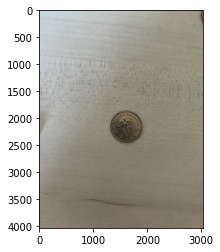

In [33]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# 10. Real Time Detections from your Webcam

In [ ]:
# !pip uninstall opencv-python-headless -y

In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# 10. Freezing the Graph

In [ ]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [ ]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

# 11. Conversion to TFJS

In [ ]:
!pip install tensorflowjs

In [ ]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

# 12. Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
print(command)

In [ ]:
!{command}